## Redes Convolucionales (con Keras)

*Adaptado de: https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial*

Para completar nuestra visión sobre las redes convolucionales vamos a construir una bastante sencilla y potente a la vez para resolver un problema ahora sencillo pero que supuso todo un hito en la visión por ordenador y en el uso de modelos DL. Vamos a reconocer digitos escritos a mano, algo que ya hemos hecho varias veces e incluso con un gran resultado empleando modelos "sencillos", lo cual ya te dará una idea del avance del campo.

Vamos a utilizar un subconjunto del dataset MNIST para simplificar las operaciones y a simplificar las etapas de construcción de un modelo de ML, pero recuerda que en la vida real no hay simplificación posible.

### Imports

Comenzamos con la carga de módulos básicos, pero dado el carácter de tutorial de las sesiones, vamos a ir haciendo los imports de algunos elementos a medida que los necesitemos

In [1]:
import bootcampviztools as bt
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


### Carga de datos y primera inspeccion

In [2]:
# read train 
df = pd.read_csv("data/mnist_clase_convo.csv")
print(df.shape)
df.head()

(21000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


En esta ocasión ya nos han proporcionado el dataset "aplanado", lo cual es interesante porque para las convolucionales lo vamos a necesitar desaplanado :-).

Además nos dan valores de pixel, pero ¿en qué escala?

In [3]:
df["pixel450"].describe()

count    21000.000000
mean         0.059810
std          2.926297
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        223.000000
Name: pixel450, dtype: float64

Parece que es entre 0 y 255, escala de grises, un sólo canal.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 125.8 MB


Y limpito sin datos missing:

In [9]:
df.isnull().sum().sum()

0

### Split de train y test

In [5]:
train_set, test_set = train_test_split(df, test_size = 0.2, stratify = df["label"], random_state = 42)

In [6]:
target = "label"

### Funciones adicionales

Antes de continuar con el miniEDA y la trasnformación de features, siempre que trabajemos con imágenes, tener a mano una forma de visualizarlas nos ayudará:

In [7]:
def plot_digits(digits,  labels = [], names = ["cero","uno","dos","tres","cuatro","cinco","seis","siete","ocho","nueve"],n_cols = 5,):
    n_rows = ((len(digits) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2.2))
    if isinstance(digits,pd.DataFrame):
        digits_val = digits.values.reshape(-1,28,28)
    else:
        digits_val = digits
    for index, digit in enumerate(digits_val):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(digit, cmap = "Greys")
        plt.axis("off")
        if len(labels):
            if isinstance(labels, pd.Series):
                plt.title(names[labels.iloc[index]])
            else:
                plt.title(names[labels[index]])
        

Esta función nos permite visualizar una conjunto, o batch, de datos ya sea una dataframe o un array de numpy, acompañándoles de sus etiquetas:

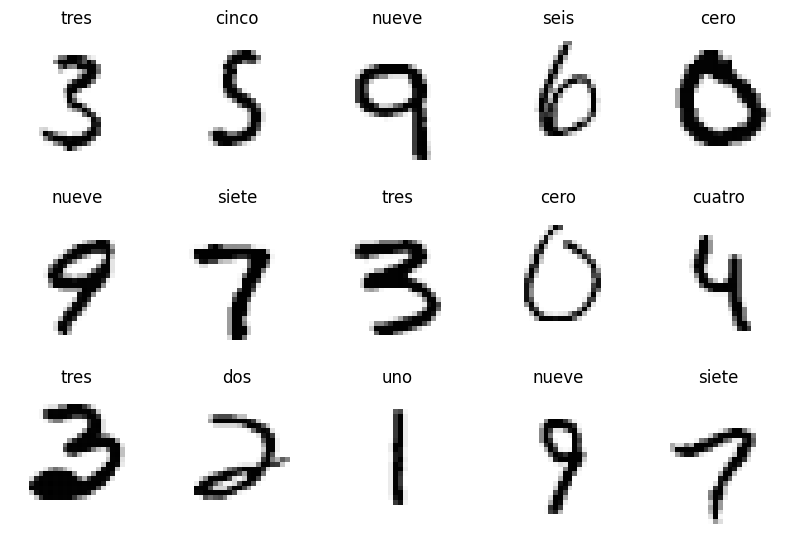

In [8]:
plot_digits(train_set.drop(target,axis = 1).iloc[1230:1245], train_set[target].iloc[1230:1245])

### MiniEDA

En este caso, no sólo por la necesidad de la sesión, sino además porque se trata de imágenes, nos centraremos en ver la distribución del target

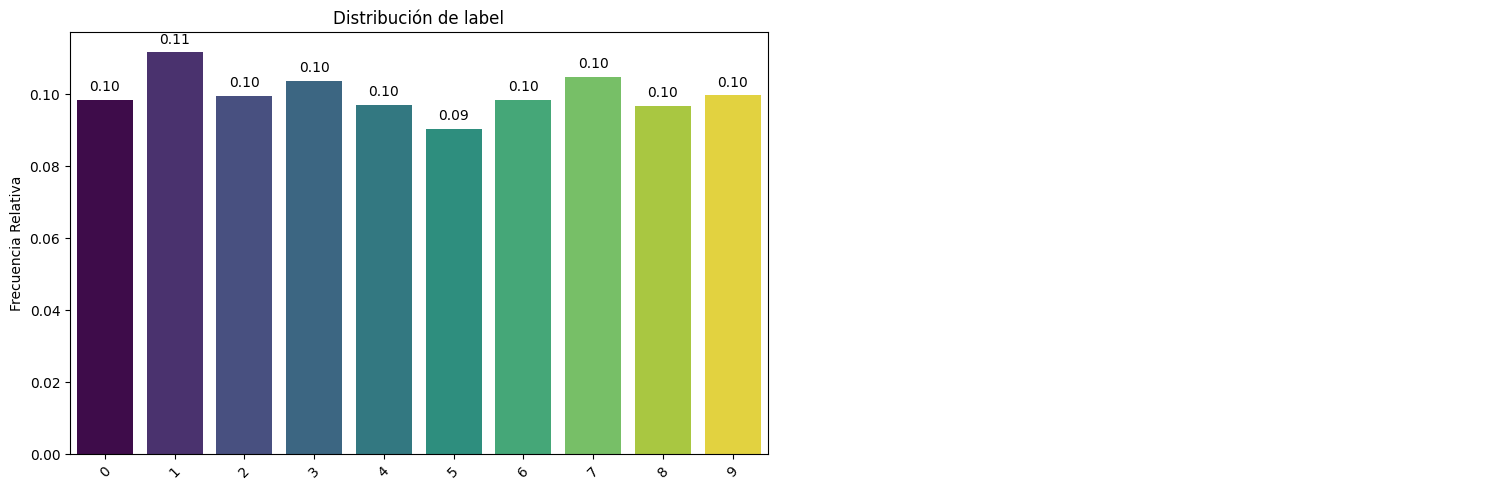

In [10]:
bt.pinta_distribucion_categoricas(train_set, [target], True, True)

Esta bastante equilibrado, con lo que una métrica como "accuracy" nos viene bien para los procesos de entrenamiento y validación.

### Transformación de features

En esta ocasión tenemos que hacer dos transformaciones:  
1. La propia de los modelos de DL, muy sensibles a la escala. Por tanto, escalamos.  
2. Como las redes convolucionales sobre imagenes esperan que les demos los datos en 2D/3D pues tenemos que "desaplanar" los datos de train y test.  

#### Escalado

Vamos a normalizar aplicando el truco de dividir por el valor máximo de la escala de grises de un píxel (que es cómo tenemos los datos), y aquí ya conviene separar (para no escalar las etiquetas):

In [11]:
X_train = train_set.drop(target,axis =1)/255
y_train = train_set[target]
X_test = test_set.drop(target,axis = 1)/255
y_test = test_set[target]

#### Desaplanado

Y ahora vamos a convertir los dataset en arrays de 28x28 (el tamaño original de las imagenes):

In [12]:
X_train = X_train.values.reshape(-1,28,28)
X_test = X_test.values.reshape(-1,28,28)

In [13]:
y_train[100:105].values

array([4, 4, 3, 8, 7], dtype=int64)

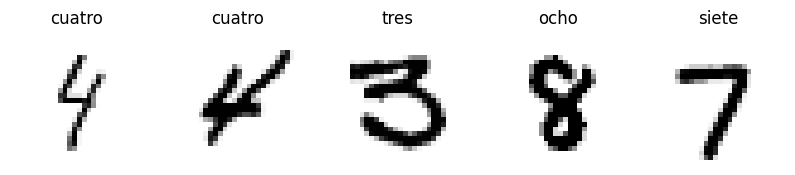

In [14]:
plot_digits(X_train[100:105],y_train[100:105].values) # A pesar del escalado el plot funciona :-)

Y ahora ya podemos construir nuestro modelo DL que en este caso será nuestra primera red convolucional:

### Modelos DL con redes convolucionales (pequeño repaso)

Como todo modelo DL, lo "farragoso" es hacer la selección correcta de los primeros hiperparámetros y variables de configuración (y lo complicado es ajustarlos después :-)):
1. Topología: Capas, unidades por capa, funciones de activación, conexión entre capas.
2. Optimizador: Qué optimizador, learning_rate (valor inicial, constante, adaptativo, etc), qué valores para los hiperparámetros propios del optimizador elegido.
3. (No son hiperparámetros, pero...) Problema: Función de pérdida, métrica
4. Entrenamiento: Batch Size, Epochs, Callbacks (Earlystop, Checkpoints,etc)

### Topología

Además de ajustar los hiperparámetros que definen la topología, vamos a ver un nuevo tipo de capa que nos permitirá obtener modelos que generalizan mejor. Es decir es un tipo de capa, no entrenable, que regulariza el modelo.

Lo primero es, por tanto, que topología. Vamos a montar algo similar a lo que nos muestra la siguiente figura:

![Captura de pantalla 2024-03-12 102720.png](<attachment:Captura de pantalla 2024-03-12 102720.png>)
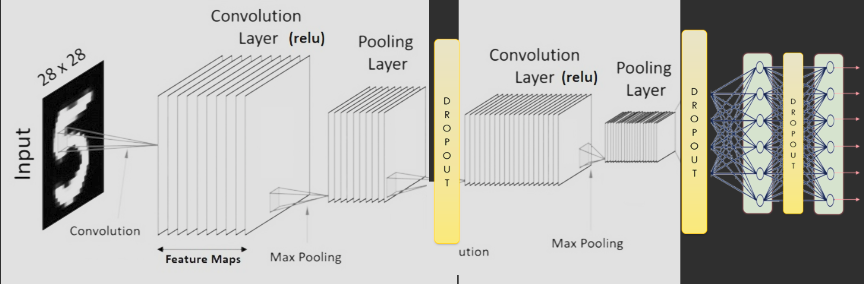

Vamos a crear dos juegos de capas convolucional y de pooling (con función de pooling el Máximo), terminaremos la red con una capa oculta y una capa de salida con 10 unidades (porque hay diez clases) a las que aplicaremos una función de activación "softmax" como ya sabemos que tenemos que hacer con problemas de clasificación.

Y añadiremos esas nuevas capas de "Dropout" (o poda) que nos servirán para regularizar el modelo (que se colocan cuando el modelo tiene cierta profundidad o cierta anchura, es decir hemos expandido mucho las features).

Ah, y nos queda una capa instrumental que no está dibujada que es la que pasará de la parte convolucional a la densa, es decir una capa "Flatten" para volver a arrays unidimensionales que son los que daremos como entrada la cabeza densa de la red.

Empecemos:

In [15]:
from keras.models import Sequential # De aquí sacamos el tipo de modelo que vamos a construir, que sigue siendo una secuencia o cadena de capas consecutivas

model = Sequential() # creamos el modelo para ir añadiendo las capas


Añadimos la primera **Capa convolucional**:
* 8 **filtros** (es como tener 8 unidades "convolucionales"), ¿cuántos filtros necesito? Depende, tendrás que jugar con este número en función del tamaño de entrada de las imagenes y el detalle fino inicial que quieras (para imagenes más grandes 16,32,64,... estas son realmente pequeñas poco detalle fino puedo encontrar).  
* 5x5 de **tamaño de Kernel (o campo receptivo, también se denomina así al kernel)**. Lo típico son 3,5 y 7. El valor depende de lo que queramos hilar de fino respecto a lo que consideremos un grupo de pixeles. Aquí vamos a pensar que cuadrado de 25 pixeles (5x5) es la agrupación adecuada. Juega con esos tres valores. Pero si la imagen está más pixelada (más borrosa) igual te merece usar kernels más grandes.  
* **Stride** de 1x1, es decir vamos a aplicar el kernel a todos los píxeles de la entrada. Esto suele ser así generalmente con la parte de la entrada  
* **Padding** a "Same", acorde con el stride de 1x1, vamos a rellenar "virtualmente" los bordes de forma que estos entren en el análisis. Same es la forma de no tener que preocuparse por el tamaño del kernel para ajustar el padding, lo autoajusta por dentro.
* Para terminar, como **función de activación** usaremos "ReLU" (que en este tipo de capas es lo habitual).

In [16]:
from keras.layers import Conv2D # Esta es la capa para convolucionales con entrada de 2 dimensiones 

model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1))) # Fijate en dos cosas, en la el input_shape (ancho,alto,num_canales) 
                                                            # y en que no decimos nada de strides (el argumento para el stride), porque por defecto está a (1,1)



Aunque no es fundamental que lo sepas a hacer, vamos a obtener el número de pesos que tendrá esta capa y la resolución de los mapas de características a la salida:

* Pesos = num_mapas (o num filtros) * (tamaño del kernel (ancho x alto) + 1 (el bias de cada unidad, recuerda que un filtro es como una "neurona convolucional"))  
* Resolución: El stride (o strides) es 1x1 y el padding es completo -> La resolución es igual a la salida es decir cada filtro va a tener 28x28 píxeles (784 features)

O sea:

In [17]:
print("Pesos a entrenar:", 8 * ( 5 * 5 + 1))
print("Resolución (features):", 28/1 * 28/1, " pero ojo como hay 8 filtros, las features las hemos ampliado a:", 28*28*8)

Pesos a entrenar: 208
Resolución (features): 784.0  pero ojo como hay 8 filtros, las features las hemos ampliado a: 6272


Ahora vamos con la **capa de pooling**, en este caso los hiperparámetros:
* Tipo de pooling, el máximo (es lo habitual)
* kernel de 2x2
* strides igual que el kernel 2x2

¿Qué queremos hacer con esta es reducir la dimensionalidad en concreto bajando la resolución de los mapas de características en 2x2 (el tamaño del stride) y quedándonos con el máximo de cada agrupación de 4 píxeles (2x2 del kernel)...

In [18]:
from keras.layers import MaxPool2D # Esta es la clase que corresponde a las capas de Pooling que hacen maxpooling sobre datos de entrada en 2D
model.add(MaxPool2D(pool_size=(2,2), strides = (2,2)))

¿Cuántos pesos tengo que entrenar en esta capa?...

¿Cuál es la "resolución" de salida y por tanto las features que tendremos (para ver la reducción)?:
$$\frac{28}{2}\times \frac{28}{2} \times \text{Numero de "filtros" de pooling}$$

¿Y cuantas capas de pooling si no hemos dicho nada? Las capas de pooling se adaptan a la capa que tengan "delante", en este caso esta capa de pooling tendrá 8 filtros o repeticiones porque es el número de filtros de la anterior capa (la convolucional). De todo esto se encarga `Keras`

$$\frac{28}{2}\times \frac{28}{2} \times 8 = 6272/4 = 1568 \text{ features}$$

Que corresponden a la bajada a 14x14 la resolución de cada mapa de características ($\frac{28}{2} \times \frac{28}{2}$)

In [19]:
14*14*8

1568

### Dropout

Lo que toca ahora es crear esa misteriosa capa de DropOut. El dropout o poda es un técnica de regularización que consiste en seleccionar aleatoriamente unidades o neuronas que se "eliminan" (podan) en el entrenamiento. En cada batch se anulan las entradas a algunas de las neuronas de las capas que vienen tras una capa de dropout y eso consigue que el modelo se esfuerce más. Es por eso una técnica de regularización.

Las capas de dropout se colocan cuando la red empieza a ser muy profunda o a expandir mucho sus features. Solo tienen un hiperparámetro que es su **ratio** que es el porcentaje de neuronas que se bloquean en cada batch. Suele estar entre 0.2 y 0.5 pero depende del número de unidades de la capa que va detrás (si tengo 2 unidades un dropout de más de 0.5 anula la capa por ejemplo).

Otra caracterírstica importante, **sólo funcionan en el entrenamiento, en la inferencia o predicción las capas de dropout se quitan** (lo hace keras por nosotros). En definitiva lo que hacen es filtrar la entrada para escoger tantas como el ratio indique y ponerlas a cero a su salida que es la que se conecta con la siguiente capa.

Para terminar, **no son entrenables** (no tienen parámetros).

Creemos nuestra capa de dropout con un ratio del 0.25 (es decir vamos a anular el 25% de las salidas de la pareja convolucional-pooling que hemos definido ya):

In [20]:
from keras.layers import Dropout

model.add(Dropout(rate= 0.25))

Ahora construimos la siguiente sección:

In [21]:
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# Resolución a la salida: Igual stride(1,1) -> 14x14
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# Resolución a la salida: 14/2 x 14/2 -> 7x7
model.add(Dropout(0.25))



Y ahora la "cabeza" de la red donde realmente se va a hacer ya la clasificación a partir de todas las features que nos ha creado nuestra parte convolucional:

Observa que añadimos primero el aplanamiento de la salida de los filtros de pooling para poder atacar a la densa... Este flatten no es cualquier flatten porque no solo aplana los 7x7 en 49 sino que además concatena cada mapa o filtro (que ahora son 16), es decir a la salida de la capa Flatten tendremos:


In [22]:
from keras.layers import Flatten, Dense

print("Entrada de la capa flatten:", model.output.shape)
model.add(Flatten()) # 49 features * Número de filtros o mapas de características -> 49*16 = 784 features -> Volvemos a las features de entrada, esto es muy típico
print("Salida de la capa flatten:",model.output.shape)
model.add(Dense(256, activation = "relu"))
# Pesos aquí (49*16+1)*256
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
# Pesos aquí (256+1)*10


Entrada de la capa flatten: (None, 7, 7, 16)
Salida de la capa flatten: (None, 784)


Pues ya tenemos la primera y más farragosa de las elecciones de hiperparámetros. Tenemos la topología continuemos con el optimizador, compilemos y entrenemos.

### Optimizador

Para **el optimizador** lo habitual ahora es emplear el **"Adam"** siempre que tengamos un size del dataset de entrenamiento bastante grande:

In [23]:
X_train.size

13171200

Sí, tiene más de un millón de datos, escogemos "Adam".

Ahora el hiperparámetros común a todos los optimizadores **el leraning rate**: En este caso empezaremos con un buen warm-up (Calentamiento es decir con un learning rate bajo), 0.001

Además "Adam" es un optimizador que tiene otros hiperparámetros para controlar la forma en que evolucioan algunos de sus cálculos con el tiempo son los **hiperparámetros: beta1 y beta2** pero que vamos a dejar a sus valores por defecto (0.9 y 0.999, respectivamente). Puedes ahondar más en los optimizadores [aqui](https://keras.io/api/optimizers/)

In [24]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate =0.001, beta_1=0.9, beta_2=0.999) #Son los parámetros por defecto, no tendríamos que haberlos indicado siquiera.

### Compilamos el modelo

Keras y Tensorflow exigen la compilación del modelo, no son dinámicos y en esa compilación tenemos que indicarle el optimizador ya creado y la función de pérdida y la métricas:

* Optimizador: Adam, ya configurado.
* Loss: sparse_categorical_crossentropy (Por que tenemos como target un escalar si fuera un vector (con un valor por cada clase) tendría que ser "categorical_crossentropy")
* Metrica: "accuracy" (porque el dataset está equilibrado)

In [25]:
# Compile the model
#model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"], run_eagerly= True)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 16)          0

### Entrenamiento

Pues casi estamos:
* Batch size, usaríamos 32, pero tenemos bastantes muestras así que vamos a subirlo a 128, si es demasiado (resultados "flojos") lo podemos bajar, pero esto acelera el entrenamiento.
* Epochs, podríamos usar un callback de earlystop pero lo ponemos a 10 y ya ajustaremos si es necesario.
* Porcentaje de validación, 0.2 para ahorrarnos crear el dataset de validación


In [27]:
X_train.shape

(16800, 28, 28)

In [28]:
batch_size = 128
epochs = 10
validation_split = 0.2

In [29]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs= epochs, validation_split= validation_split)

Epoch 1/10


105/105 [==============================] - 1s 7ms/step - loss: 1.0239 - accuracy: 0.6641 - val_loss: 0.3336 - val_accuracy: 0.9077
Epoch 2/10
105/105 [==============================] - 1s 5ms/step - loss: 0.4117 - accuracy: 0.8678 - val_loss: 0.2090 - val_accuracy: 0.9390
Epoch 3/10
105/105 [==============================] - 1s 5ms/step - loss: 0.3058 - accuracy: 0.9040 - val_loss: 0.1513 - val_accuracy: 0.9542
Epoch 4/10
105/105 [==============================] - 1s 5ms/step - loss: 0.2436 - accuracy: 0.9220 - val_loss: 0.1236 - val_accuracy: 0.9640
Epoch 5/10
105/105 [==============================] - 0s 5ms/step - loss: 0.2064 - accuracy: 0.9328 - val_loss: 0.1091 - val_accuracy: 0.9661
Epoch 6/10
105/105 [==============================] - 1s 5ms/step - loss: 0.1809 - accuracy: 0.9436 - val_loss: 0.0940 - val_accuracy: 0.9732
Epoch 7/10
105/105 [==============================] - 0s 5ms/step - loss: 0.1677 - accuracy: 0.9472 - val_loss: 0.0824 - val_accuracy: 0.9732
Epoc

No tiene mala pinta :-)

Veamos la historia del entrenamiento:

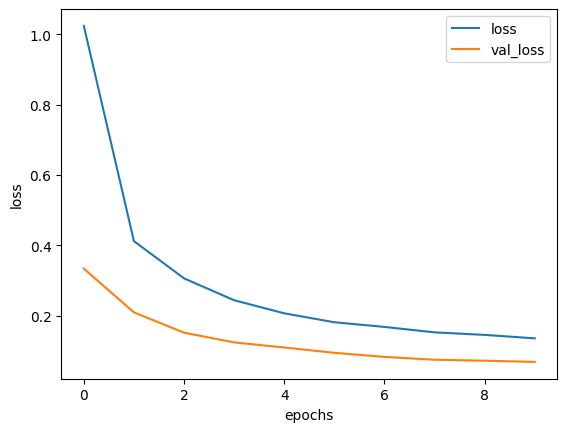

In [30]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

In [31]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.023925,0.664137,0.333627,0.907738
1,0.411711,0.867783,0.209048,0.938988
2,0.305837,0.904018,0.151259,0.954167
3,0.243588,0.922024,0.123633,0.963988
4,0.206400,0.932813,0.109144,0.966071
5,0.180927,0.943601,0.094019,0.973214
6,0.167691,0.947173,0.082353,0.973214
7,0.152179,0.951339,0.074293,0.977679
8,0.144998,0.954687,0.071551,0.976786
9,0.135167,0.958185,0.068101,0.978571


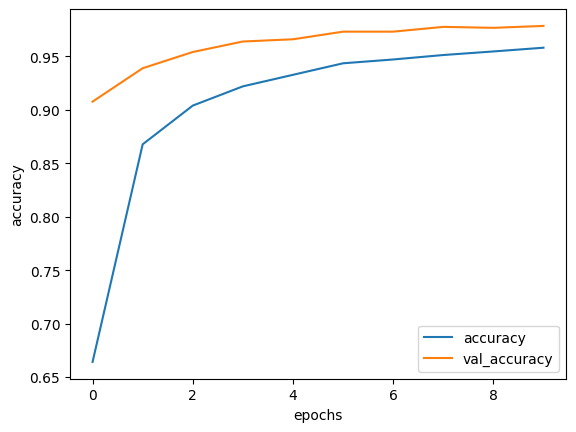

In [32]:
history_df = pd.DataFrame(history.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

En ambos casos, ya comenzó con una muy buenas prestaciones en validación frente al train, no suele ser así en el que el train converge hacia un validation mejor... Evaluemos el modelo contra test a ver que tal generaliza

### Evaluación del modelo

In [33]:
model.evaluate(X_test,y_test)

132/132 [==============================] - 0s 1ms/step - loss: 0.0723 - accuracy: 0.9781


[0.07233889400959015, 0.9780952334403992]

Hmm, está francamente bien. Mejor que en el entrenamiento. Veamos el report y la matriz de confusión

In [34]:
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]


132/132 [==============================] - 0s 1ms/step


In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       413
           1       0.99      0.99      0.99       468
           2       0.96      0.99      0.98       418
           3       0.96      0.98      0.97       435
           4       0.98      0.98      0.98       407
           5       0.99      0.98      0.99       379
           6       0.98      0.99      0.98       414
           7       0.99      0.97      0.98       440
           8       0.98      0.96      0.97       407
           9       0.96      0.95      0.95       419

    accuracy                           0.98      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.98      0.98      0.98      4200



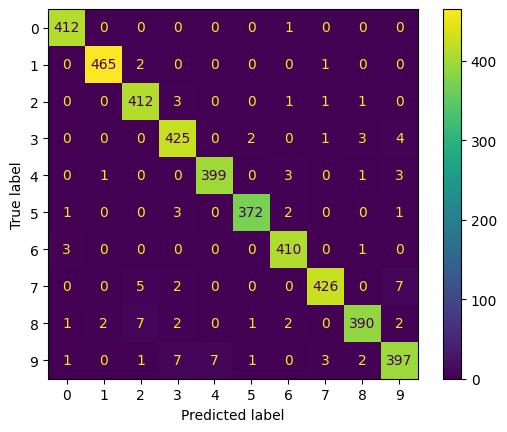

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

Espectacular a penas hay fallos.

En general no van a salir así, porque no tendrás imágenes tan centradas o tendremos que hacer un preprocesado primero para seleccionar los objetos o tiraremos de modelos más complejos como veremos en la unidad siguiente.